# Tavily Scraping Assignment – Analysis Notebook

This notebook implements and evaluates a two-stage scraping pipeline over a set of ~1,000 "hard" URLs.

**Goals:**
- Compare a lightweight HTTP client vs. a JS-enabled browser (Playwright).
- Respect `robots.txt` and detect CAPTCHAs (without bypassing them).
- Quantify trade-offs between latency, success rate, and cost.

In [1]:
from pathlib import Path
import sys

# Ensure project root (folder containing `src/`) is on sys.path so we can import local modules.
repo_root = Path.cwd()
while repo_root != repo_root.parent and not (repo_root / "src").exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root))
print("Repo root set to:", repo_root)

Repo root set to: /Users/gabrielzackon/tavily-scraper


## 1. Environment & imports
We start by checking the Python environment and ensuring local project modules under `src/` are importable.

In [2]:
# Environment info
# (If running in a fresh environment / Colab, install dependencies with the commented commands below.)

# %pip install aiohttp httpx playwright pandas numpy pyarrow matplotlib beautifulsoup4 lxml \
#               readability-lxml tldextract charset-normalizer langdetect pydantic tenacity tqdm rich \
#               python-dotenv pyyaml
# !playwright install

import sys
import platform
import pandas as pd

print("Python:", sys.version)
print("Platform:", platform.platform())

Python: 3.11.13 (main, Jun  5 2025, 08:14:07) [Clang 14.0.6 ]
Platform: macOS-10.16-x86_64-i386-64bit


## 2. Scraping configuration (YAML-driven)

All scraping parameters (timeouts, concurrency, browser behavior, robots cache, proxy usage) are centralized in a `ScrapeConfig` dataclass, loaded from `scrape_config.yaml`. This makes it easy to tune latency/cost/reliability without modifying the notebook code.

In [3]:
from src.settings import DEFAULT_SCRAPE_CONFIG

# Inspect the active configuration loaded from `scrape_config.yaml`
DEFAULT_SCRAPE_CONFIG

ScrapeConfig(use_proxy=True, user_agent='Mozilla/5.0 (TavilyCandidateBot)', captcha_detection_bytes=4096, http_concurrency=20, http_total_timeout_s=20.0, http_connect_timeout_s=10.0, http_sock_read_timeout_s=15.0, http_max_retries=1, http_retry_base_delay_s=0.1, http_retry_jitter_s=0.2, browser_timeout_ms=20000, browser_headless=True, browser_block_heavy=True, max_browser_escalations=100, browser_locale='en-US', robots_cache_path='data/robots_cache.json', robots_cache_ttl_s=86400, escalation_min_bytes=2048, escalation_consider_latency=False, escalation_latency_s=5.0)

## 3. Inputs: proxy and URL set

We now load:
- Proxy credentials from `data/ProxyURL.txt`.
- The input URL list (`failed_urls.csv`), which contains a mix of static and JS-heavy pages.

For later analysis we also normalize each URL to its registered domain.

In [4]:
import tldextract
from src.settings import load_proxy_from_txt

# Load proxy configuration (if present)
PROXY = load_proxy_from_txt("../data/ProxyURL.txt")
print("Proxy configured:", bool(PROXY.server))
print("Proxy (masked):", 
      (PROXY.server[:12] + "..." + PROXY.server[-8:]) if PROXY.server else None)

# Load URL list and basic cleaning
urls_df = (
    pd.read_csv("../data/failed_urls.csv")
      .dropna(subset=["url"])
      .drop_duplicates("url")
)

def extract_domain(url: str) -> str | None:
    """Extract normalized registrable domain for grouping / sampling."""
    try:
        return tldextract.extract(url).top_domain_under_public_suffix
    except Exception:
        return None

urls_df["domain"] = urls_df["url"].map(extract_domain)

print("Total URLs loaded:", len(urls_df))
display(urls_df.head())

Proxy file not found: /Users/gabrielzackon/tavily-scraper/../data/ProxyURL.txt
Proxy configured: False
Proxy (masked): None
Total URLs loaded: 10000


,url,domain
0,https://www.crunchbase.com/person/scott-c-kay,crunchbase.com
1,https://x.com/peignoir,x.com
2,https://lawyerly.ph/digest/cc500?user=4984,lawyerly.ph
3,https://jur.ph/jurisprudence/summary/austria-v...,jur.ph
4,http://www.iea.org/countries/the-netherlands,iea.org


## 4. Sampling strategy

To keep the experiment tractable while still covering a variety of sites, we:
- Cap the number of URLs per domain (to avoid over-representing any single host).
- Draw a random sample of up to `target_n` URLs from the capped set.

This approximates a real-world scenario where we want diversity across domains.

In [5]:
# Cap the number of URLs per domain and sample overall
cap_per_domain = 20
target_n = 1000

# First, limit each domain to at most `cap_per_domain` URLs
per_domain = urls_df.groupby("domain", group_keys=False).apply(
    lambda g: g.sample(min(len(g), cap_per_domain), random_state=42)
)

# Then sample up to `target_n` URLs overall
sample_df = (
    per_domain
    .sample(n=min(target_n, len(per_domain)), random_state=42)
    .reset_index(drop=True)
)

print("Sample size:", len(sample_df))
display(sample_df.head())

Sample size: 1000


/var/folders/jz/c2kgs0xx12ndmm7j0dymp8k80000gn/T/ipykernel_24974/4281598734.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_domain = urls_df.groupby("domain", group_keys=False).apply(


,url,domain
0,https://luatminhkhue.vn/chuyen-nhuong-quyen-su...,luatminhkhue.vn
1,https://whitestown.in.gov/whitestown-documents...,in.gov
2,https://www.resumai.com/post/ats-cv-builder,resumai.com
3,https://support.ankersolix.com/s/article/How-C...,ankersolix.com
4,https://jobs.interiorhealth.ca/ViewJobPosting/...,interiorhealth.ca


## 5. Stage 1 – HTTP scraping (lightweight client)

We first scrape the sampled URLs using an `aiohttp`-based client:

- Respects `robots.txt` via a persistent `RobotsCache`.
- Uses configurable concurrency and timeouts (`ScrapeConfig`).
- Records per-URL metrics: latency (TTL/TTFB), status, bytes, errors, and basic CAPTCHA detection.

In [6]:
import aiohttp
import asyncio
import random
import tldextract

from src.http_scraper import HttpScraper
from src.robots import RobotsCache
from src.metrics import FetchResult
from src.utils import robots_blocked_result, RETRYABLE_ERRORS
from src.settings import ScrapeConfig, DEFAULT_SCRAPE_CONFIG, ProxySettings


def attach_domain(fr: FetchResult) -> FetchResult:
    """Attach normalized registrable domain to a FetchResult for grouping/analysis."""
    try:
        fr.domain = tldextract.extract(fr.url).top_domain_under_public_suffix
    except Exception:
        fr.domain = None
    return fr


async def run_http(
    urls: list[str],
    proxy_settings: ProxySettings | None = None,
    config: ScrapeConfig = DEFAULT_SCRAPE_CONFIG,
) -> list[FetchResult]:
    """
    Fetch a batch of URLs using aiohttp with:
    - robots.txt checks via RobotsCache
    - bounded concurrency via Semaphore
    - optional retry on transport-level errors
    """
    timeout = aiohttp.ClientTimeout(
        total=config.http_total_timeout_s,
        connect=config.http_connect_timeout_s,
        sock_read=config.http_sock_read_timeout_s,
    )
    connector = aiohttp.TCPConnector(limit_per_host=8, ttl_dns_cache=300)
    sem = asyncio.Semaphore(config.http_concurrency)
    results: list[FetchResult] = []

    async with aiohttp.ClientSession(timeout=timeout, connector=connector) as session:
        scraper = HttpScraper(session, config=config, proxy=proxy_settings)
        robots = RobotsCache(session, config=config)

        async def fetch_one(u: str) -> FetchResult:
            """Respect robots.txt, then perform the actual HTTP fetch with optional retries."""
            async with sem:
                try:
                    allowed = await robots.allowed(u)
                except Exception:
                    # If robots.txt fails to load, fall back to permissive.
                    allowed = True

                if not allowed:
                    fr = robots_blocked_result(u)
                    fr.proxy_hint = "proxy" if (config.use_proxy and proxy_settings) else "direct"
                    return fr

                last_result: FetchResult | None = None
                max_retries = config.http_max_retries

                for attempt in range(max_retries + 1):
                    last_result = await scraper.fetch(u)

                    # If error is not retryable (or no error), stop retry loop
                    if last_result.error_type not in RETRYABLE_ERRORS:
                        last_result.retry_count = attempt
                        break

                    # Retry with small jitter
                    if attempt < max_retries:
                        delay = config.http_retry_base_delay_s + config.http_retry_jitter_s * random.random()
                        await asyncio.sleep(delay)
                    else:
                        last_result.retry_count = max_retries

                last_result.proxy_hint = "proxy" if (config.use_proxy and proxy_settings) else "direct"
                return last_result

        tasks = [asyncio.create_task(fetch_one(u)) for u in urls]
        for t in asyncio.as_completed(tasks):
            r = await t
            results.append(attach_domain(r))

    return results


# Run the HTTP stage over the sampled URLs
http_results = await run_http(
    sample_df["url"].tolist(),
    config=DEFAULT_SCRAPE_CONFIG,
    proxy_settings=PROXY,
)
len(http_results)

1000

### 5.1 HTTP results → DataFrame & failure classification

We convert the list of `FetchResult` objects into a DataFrame, classify failures into
high-level buckets (robots, CAPTCHA, HTTP errors, transport errors), and inspect retry behavior.

In [7]:
from dataclasses import asdict

def to_df(results: list[FetchResult]) -> pd.DataFrame:
    """Convert a list of FetchResult dataclasses into a pandas DataFrame."""
    return pd.DataFrame([asdict(r) for r in results]) if results else pd.DataFrame()


def classify_failure(row: pd.Series) -> str:
    """
    Map low-level error/status details into a small set of failure buckets:
    - robots_blocked
    - captcha
    - http_<status>
    - transport_error
    - ok
    """
    if row["error_type"] == "robots_blocked":
        return "robots_blocked"
    if row["captcha"]:
        return "captcha"
    if pd.notna(row["status"]) and row["status"] >= 400:
        return f"http_{int(row['status'])}"
    if pd.isna(row["status"]) and row["error_type"]:
        return "transport_error"
    return "ok"


# Build DataFrame from HTTP results
df_http = to_df(http_results)

# Add a clear failure bucket column
df_http["failure_reason"] = df_http.apply(classify_failure, axis=1)

# Basic retry stats
avg_retries = df_http["retry_count"].mean()
max_retries = df_http["retry_count"].max()

print(f"Average HTTP retries per URL: {avg_retries:.3f}")
print("Max retries for any URL:", max_retries)

print("\nRetry distribution (attempts per URL):")
display(df_http["retry_count"].value_counts().sort_index())

display(
    df_http.head(10)
)

df_http["failure_reason"].value_counts()

Average HTTP retries per URL: 0.057
Max retries for any URL: 1

Retry distribution (attempts per URL):


retry_count
0    943
1     57
Name: count, dtype: int64

,url,scraper,bytes_len,captcha,ttl_s,ttfb_s,error_type,status,domain,proxy_hint,retry_count,failure_reason
0,https://luatminhkhue.vn/chuyen-nhuong-quyen-su...,http,9722,False,0.075723,0.075707,None,403.0,luatminhkhue.vn,proxy,0,http_403
1,https://npidb.org/organizations/ambulatory_hea...,http,9796,False,0.083348,0.083332,None,403.0,npidb.org,proxy,0,http_403
2,https://rri.co.id/nasional/1868766/begini-nask...,http,9724,False,0.084886,0.083817,None,403.0,rri.co.id,proxy,0,http_403
3,https://www.ajconline.org/article/S0002-9149(2...,http,9588,False,0.086567,0.083879,None,403.0,ajconline.org,proxy,0,http_403
4,https://www.pharmacity.vn/pharmacity-day-manh-...,http,9781,False,0.089709,0.088046,None,403.0,pharmacity.vn,proxy,0,http_403
5,https://www.omnihotels.com/media-center/recent...,http,9503,False,0.092059,0.092047,None,403.0,omnihotels.com,proxy,0,http_403
6,https://luatminhkhue.vn/tom-tat-cuoc-gap-go-ti...,http,9540,False,0.095614,0.094831,None,403.0,luatminhkhue.vn,proxy,0,http_403
7,https://www.tsn.ca/radio/ottawa-1200/article/o...,http,178546,False,0.275918,0.275903,None,200.0,tsn.ca,proxy,0,ok
8,https://www.linux.org/threads/virtualbox-for-l...,http,183517,False,0.305155,0.305141,None,200.0,linux.org,proxy,0,ok
9,https://karger.com/jin/article-pdf/doi/10.1159...,http,9153,False,0.044493,0.044484,None,403.0,karger.com,proxy,0,http_403


failure_reason
ok                 468
http_403           223
captcha            119
transport_error     87
robots_blocked      49
http_404            27
http_429            15
http_500             4
http_503             3
http_522             2
http_400             2
http_410             1
Name: count, dtype: int64

### 5.2 Inspect transport-level errors

For debugging and analysis, we look at which exceptions dominate the `transport_error` bucket and which domains are most affected.

In [8]:
# Filter to transport-level errors (e.g., proxy issues, SSL errors, timeouts)
transport = df_http[df_http["failure_reason"] == "transport_error"]

print("Transport errors:", len(transport), "out of", len(df_http))
display(
    transport["error_type"]
    .value_counts()
    .rename_axis("error_type")
    .reset_index(name="count")
)

# Top domains experiencing transport errors
transport_domain = (
    transport.groupby("domain")["url"]
    .count()
    .sort_values(ascending=False)
    .head(10)
    .rename("count")
    .reset_index()
)

print("\nTop domains by transport errors:")
display(transport_domain)

Transport errors: 87 out of 1000


,error_type,count
0,TimeoutError,51
1,ClientConnectorCertificateError,13
2,ClientConnectorDNSError,10
3,ClientConnectorError,5
4,ClientConnectorSSLError,3
5,TooManyRedirects,2
6,ServerDisconnectedError,1
7,ClientResponseError,1
8,ClientOSError,1



Top domains by transport errors:


,domain,count
0,dnb.com,5
1,loopnet.ca,4
2,loopnet.com,4
3,stone.edu,3
4,uinjkt.ac.id,3
5,moi.gov.mm,2
6,iitd.ac.in,2
7,grid-india.in,2
8,ascee.org,1
9,ar-raniry.ac.id,1


## 6. Stage 2 – Browser scraping (Playwright)

For URLs that are likely to need dynamic rendering (e.g., suspected JS-heavy or blocked in HTTP), we escalate to a Playwright-based browser scraper. We re-use a single browser instance for efficiency and cap the maximum number of escalations per run.

In [9]:
from src.browser_scraper import BrowserScraper

async def run_browser(
    urls: list[str],
    proxy_settings: ProxySettings | None = None,
    config: ScrapeConfig = DEFAULT_SCRAPE_CONFIG,
) -> list[FetchResult]:
    """
    Run Playwright-based scraping on a subset of URLs.

    - Reuses a single browser/context via BrowserScraper.
    - Optionally uses the proxy, depending on config.use_proxy.
    - Caps the number of escalated URLs via config.max_browser_escalations.
    """
    if not urls:
        return []

    proxy = proxy_settings if (config.use_proxy and proxy_settings is not None) else None
    results: list[FetchResult] = []

    async with BrowserScraper(config=config, proxy=proxy) as br:
        # Limit Playwright usage — avoid escalating too many URLs
        for u in urls[: config.max_browser_escalations]:
            r = await br.fetch(u)
            r.proxy_hint = "proxy" if (config.use_proxy and proxy_settings is not None) else "direct"
            results.append(r)

    return results

### 6.1 Escalation policy → Browser results

We apply a simple escalation policy (`should_escalate`) over the HTTP results to decide which URLs should be retried in a full browser. Then we run Playwright on that subset and classify failures.

In [10]:
from src.policy import should_escalate

# Decide which HTTP results should be escalated to the browser
need_browser_mask = df_http.apply(
    lambda row: should_escalate(type("R", (object,), row.to_dict())()),
    axis=1,
)

max_cap = DEFAULT_SCRAPE_CONFIG.max_browser_escalations
to_browser = df_http[need_browser_mask]["url"].head(max_cap).tolist()  # extra cap for cost safety

browser_results = await run_browser(
    to_browser,
    proxy_settings=PROXY,
    config=DEFAULT_SCRAPE_CONFIG,
)

df_browser = to_df(browser_results)

# Ensure retry_count exists for browser policy (0 for all in this implementation)
if "retry_count" not in df_browser.columns:
    df_browser["retry_count"] = 0

df_browser["failure_reason"] = df_browser.apply(classify_failure, axis=1)

print("Escalated URLs:", len(to_browser), " | Browser results:", len(df_browser))
display(df_browser.head(10))
df_browser["failure_reason"].value_counts()


Escalated URLs: 100  | Browser results: 100


,url,scraper,bytes_len,captcha,ttl_s,ttfb_s,error_type,status,domain,proxy_hint,retry_count,failure_reason
0,https://luatminhkhue.vn/chuyen-nhuong-quyen-su...,browser,18761,False,0.688695,0.658926,None,403.0,None,proxy,0,http_403
1,https://npidb.org/organizations/ambulatory_hea...,browser,8305,False,0.328825,0.314305,None,403.0,None,proxy,0,http_403
2,https://rri.co.id/nasional/1868766/begini-nask...,browser,11028,False,0.361586,0.348888,None,403.0,None,proxy,0,http_403
3,https://www.ajconline.org/article/S0002-9149(2...,browser,322589,False,4.298384,4.206947,None,200.0,None,proxy,0,ok
4,https://www.pharmacity.vn/pharmacity-day-manh-...,browser,18847,False,0.376676,0.295472,None,403.0,None,proxy,0,http_403
5,https://www.omnihotels.com/media-center/recent...,browser,876391,False,3.454669,3.263205,None,200.0,None,proxy,0,ok
6,https://luatminhkhue.vn/tom-tat-cuoc-gap-go-ti...,browser,18110,False,0.412484,0.330302,None,403.0,None,proxy,0,http_403
7,https://karger.com/jin/article-pdf/doi/10.1159...,browser,0,False,1.897664,NaN,Error,NaN,None,proxy,0,transport_error
8,https://www.muskoka.on.ca/en/careers-and-volun...,browser,0,False,0.921862,NaN,Error,NaN,None,proxy,0,transport_error
9,https://app.spaceinsider.tech/companies?countr...,browser,2991,False,0.795193,0.778756,None,200.0,None,proxy,0,ok


failure_reason
http_403           42
ok                 22
transport_error    15
http_404           11
http_429            6
http_500            2
captcha             1
http_503            1
Name: count, dtype: int64

## 7. Policy comparison – HTTP vs Browser vs Hybrid

We compare three policies:

- **http_only**: Use HTTP client only.
- **browser_only**: Use only Playwright.
- **hybrid_best_of**: For each URL, pick the best result across HTTP+Browser,
  preferring successful responses and then larger content size.

In [11]:
# Mark source for merging
df_http_ = df_http.assign(source="http")
df_browser_ = df_browser.assign(source="browser")

combined = pd.concat([df_http_, df_browser_], ignore_index=True, sort=False)

# Success flag: no error, no captcha, HTTP status < 400
combined["ok"] = (
    combined["error_type"].isna()
    & ~combined["captcha"]
    & (combined["status"].fillna(0) < 400)
)

# Pick "best" row per URL (prefer ok; then larger bytes)
best_idx = (
    combined
    .sort_values(["ok", "bytes_len"], ascending=[True, False])
    .groupby("url", as_index=False)
    .head(1)
    .index
)

hybrid = combined.loc[best_idx].copy()
hybrid["policy"] = "hybrid_best_of"
hybrid["failure_reason"] = hybrid.apply(classify_failure, axis=1)

http_only = df_http.copy()
http_only["policy"] = "http_only"

browser_only = df_browser.copy()
browser_only["policy"] = "browser_only"


def summarize(df: pd.DataFrame, name: str) -> pd.Series:
    """Compute basic metrics for a given scraping policy."""
    success_mask = (
        df["error_type"].isna()
        & ~df["captcha"]
        & (df["status"].fillna(0) < 400)
    )
    return pd.Series({
        "policy": name,
        "n": len(df),
        "success_rate": success_mask.mean(),
        "avg_ttl_s": df["ttl_s"].mean(),
        "p50_bytes": df["bytes_len"].median(),
        "p90_bytes": df["bytes_len"].quantile(0.90),
        "avg_retries": df.get("retry_count", 0).mean(),
        "max_retries": df.get("retry_count", 0).max(),
    })


summary = pd.concat([
    summarize(http_only, "http_only"),
    summarize(browser_only, "browser_only"),
    summarize(hybrid, "hybrid_best_of"),
], axis=1).T.set_index("policy")

display(summary)

,n,success_rate,avg_ttl_s,p50_bytes,p90_bytes,avg_retries,max_retries
policy,,,,,,,
http_only,1000,0.468,1.886838,9825.5,679785.9,0.057,1
browser_only,100,0.22,1.185087,7966.5,867428.8,0.0,0
hybrid_best_of,1000,0.468,1.903577,9886.0,683466.4,0.057,1


## 8. Cost model – HTTP vs Browser vs Hybrid

To tie the engineering decisions back to Tavily’s core trade-offs (latency, accuracy, cost), we define a simple unit cost model:

- 1 cost unit per HTTP request (lightweight client).
- 8 cost units per browser-based request (Playwright).

Using the policy summary table, we estimate:
- how many HTTP/browser calls each policy makes,
- the total cost in "units",
- and the effective **cost per successful page**.

In [12]:
import numpy as np

# Cost assumptions (could also be added to YAML config eventually)
HTTP_UNIT_COST = 1.0         # cost of one HTTP fetch
BROWSER_UNIT_COST = 8.0      # cost of one browser-rendered fetch (heavier)

n_http_calls = len(df_http)
n_browser_calls = len(df_browser)

print("HTTP calls:", n_http_calls,
      "| Browser calls:", n_browser_calls,
      "| Hybrid URLs:", len(hybrid))

summary_cost = summary.copy()

summary_cost["http_calls"] = 0
summary_cost["browser_calls"] = 0

# Assign call counts per policy
summary_cost.loc["http_only",    ["http_calls", "browser_calls"]] = [n_http_calls, 0]
summary_cost.loc["browser_only", ["http_calls", "browser_calls"]] = [0, n_browser_calls]
summary_cost.loc["hybrid_best_of", ["http_calls", "browser_calls"]] = [n_http_calls, n_browser_calls,]

# Total cost = (#http * cost_http) + (#browser * cost_browser)
summary_cost["total_cost_units"] = (
    summary_cost["http_calls"] * HTTP_UNIT_COST
    + summary_cost["browser_calls"] * BROWSER_UNIT_COST
)

# Compute estimated successful pages per policy
summary_cost["successes"] = summary_cost["n"] * summary_cost["success_rate"]

summary_cost["cost_per_success"] = (summary_cost["total_cost_units"] / summary_cost["successes"].replace(0, np.nan))

display(summary_cost)

HTTP calls: 1000 | Browser calls: 100 | Hybrid URLs: 1000


,n,success_rate,avg_ttl_s,p50_bytes,p90_bytes,avg_retries,max_retries,http_calls,browser_calls,total_cost_units,successes,cost_per_success
policy,,,,,,,,,,,,
http_only,1000,0.468,1.886838,9825.5,679785.9,0.057,1,1000,0,1000.0,468.0,2.136752
browser_only,100,0.22,1.185087,7966.5,867428.8,0.0,0,0,100,800.0,22.0,36.363636
hybrid_best_of,1000,0.468,1.903577,9886.0,683466.4,0.057,1,1000,100,1800.0,468.0,3.846154


### 8.1 Cost per success visualization

We visualize the cost-per-success metric across the three policies to see where the
hybrid approach lands relative to HTTP-only and Browser-only in terms of efficiency.

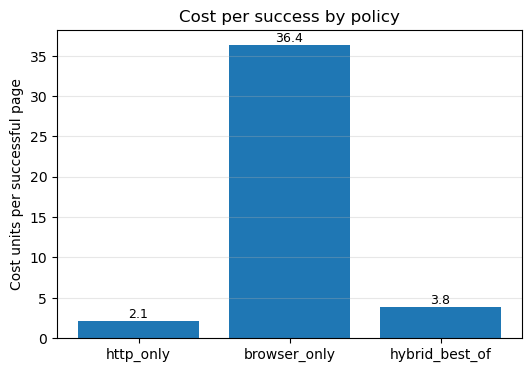

In [13]:
import numpy as np
import matplotlib.pyplot as plt

policies = summary_cost.index.tolist()
x = np.arange(len(policies))
y = summary_cost["cost_per_success"].astype(float).values

plt.figure(figsize=(6,4))
bars = plt.bar(x, y)

# Annotate bar values
for xi, bar in zip(x, bars):
    height = bar.get_height()
    if np.isnan(height):
        continue
    plt.text(
        xi,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.xticks(x, policies)
plt.ylabel("Cost units per successful page")
plt.title("Cost per success by policy")
plt.grid(axis="y", alpha=0.3)
plt.show()


## 9. Performance & failure patterns

Next, we look at how each policy behaves in terms of:

- **Latency distribution** for successful requests.
- **Failure mix** (robots, CAPTCHAs, HTTP errors, transport errors).

This helps understand *why* the policies differ in success rate and cost.

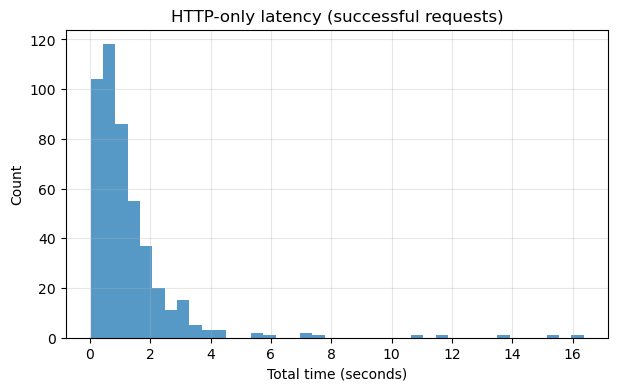

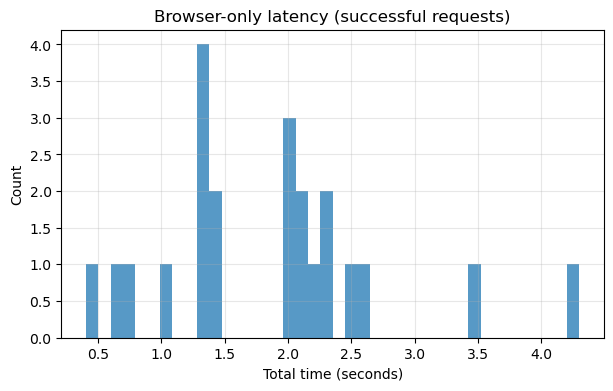

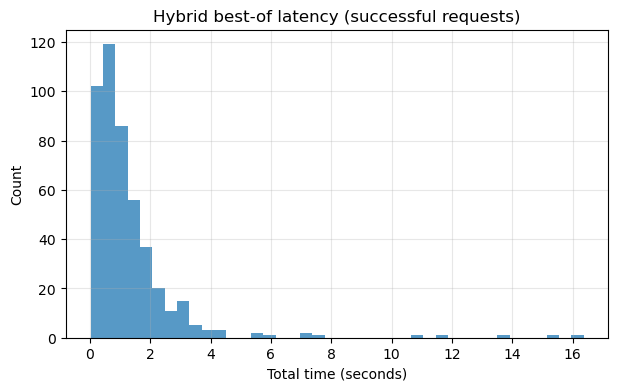

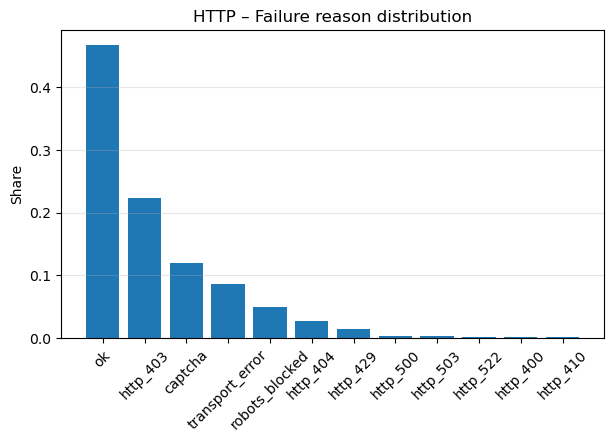

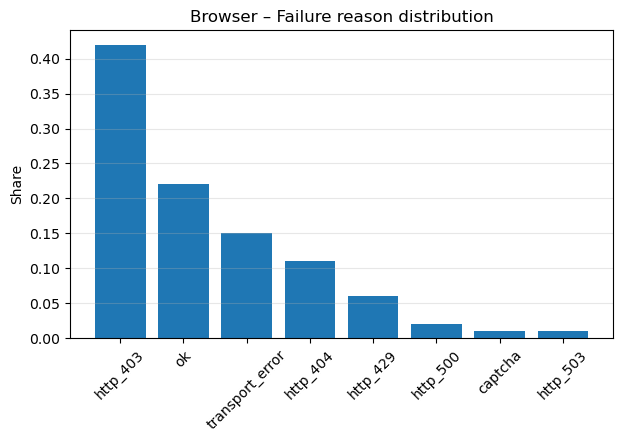

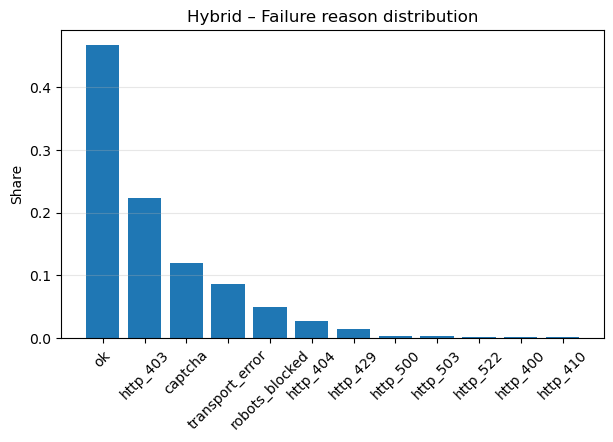

In [14]:
import matplotlib.pyplot as plt

def plot_latency_hist(df, title):
    ok_mask = (
        df["error_type"].isna()
        & (df["status"].fillna(0) < 400)
        & (~df["captcha"])
    )
    ok_rows = df[ok_mask]

    if ok_rows.empty:
        print(f"No successful rows for {title}")
        return

    plt.figure(figsize=(7,4))
    ok_rows["ttl_s"].hist(bins=40, alpha=0.75)
    plt.xlabel("Total time (seconds)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

plot_latency_hist(http_only,   "HTTP-only latency (successful requests)")
plot_latency_hist(browser_only,"Browser-only latency (successful requests)")
plot_latency_hist(hybrid,      "Hybrid best-of latency (successful requests)")


# --- Failure mix per policy ---
for name, df in [("HTTP", http_only), ("Browser", browser_only), ("Hybrid", hybrid)]:
    fr = (
        df["failure_reason"]
        .value_counts(normalize=True)
        .rename_axis("reason")
        .reset_index(name="share")
    )

    plt.figure(figsize=(7,4))
    plt.bar(fr["reason"], fr["share"])
    plt.title(f"{name} – Failure reason distribution")
    plt.ylabel("Share")
    plt.xticks(rotation=45)
    plt.grid(axis="y", alpha=0.3)
    plt.show()

### 9.1 Latency vs. content size

We also plot latency vs. content size per policy. This highlights whether:
- Browser-based scraping tends to return heavier pages,
- and whether heavier pages systematically cost more time.

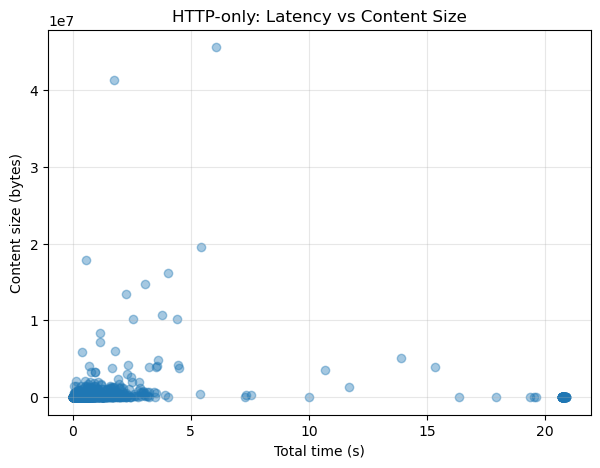

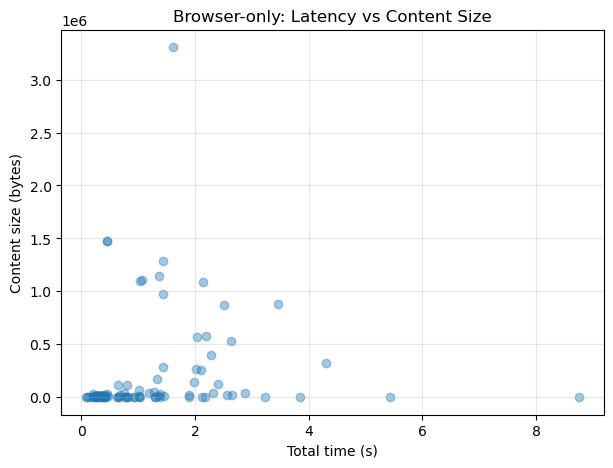

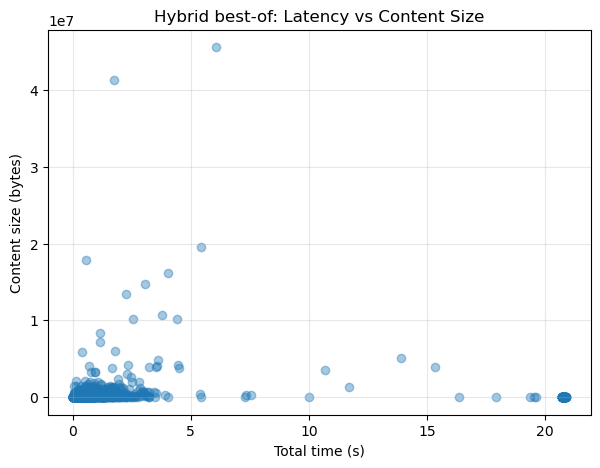

In [15]:
import matplotlib.pyplot as plt

def scatter_latency_size(df, title):
    if df.empty:
        print(f"No data for {title}")
        return

    plt.figure(figsize=(7,5))
    plt.scatter(df["ttl_s"], df["bytes_len"], alpha=0.4)
    plt.xlabel("Total time (s)")
    plt.ylabel("Content size (bytes)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

scatter_latency_size(http_only,   "HTTP-only: Latency vs Content Size")
scatter_latency_size(browser_only,"Browser-only: Latency vs Content Size")
scatter_latency_size(hybrid,      "Hybrid best-of: Latency vs Content Size")

### 9.2 Content size distribution

Finally, we compare the distribution of scraped content size (bytes) for each policy.
Combined with the failure analysis, this gives a rough picture of how much "useful content" we get per unit of effort.

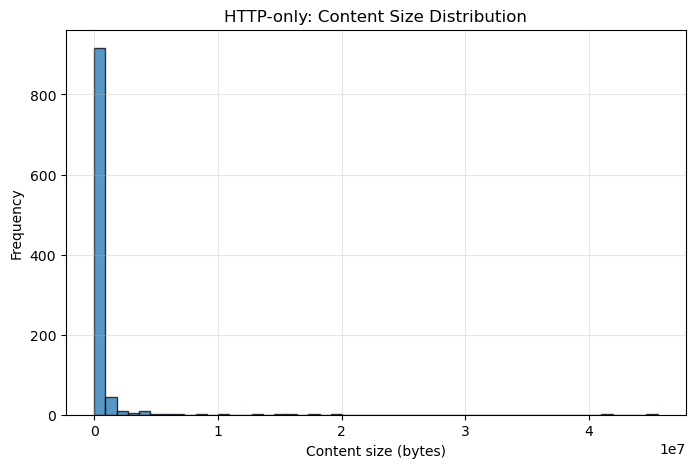

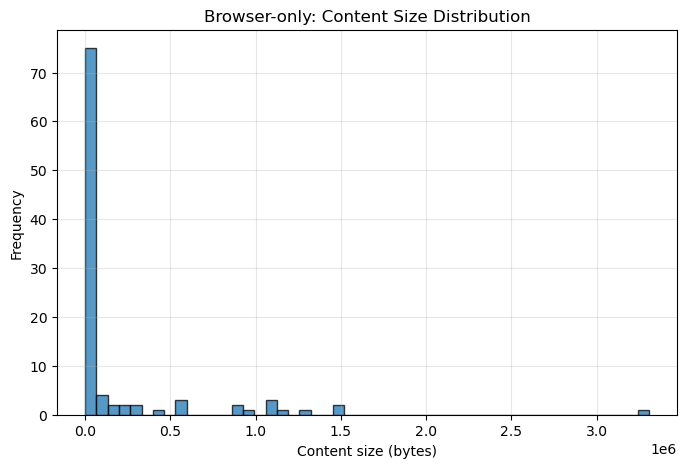

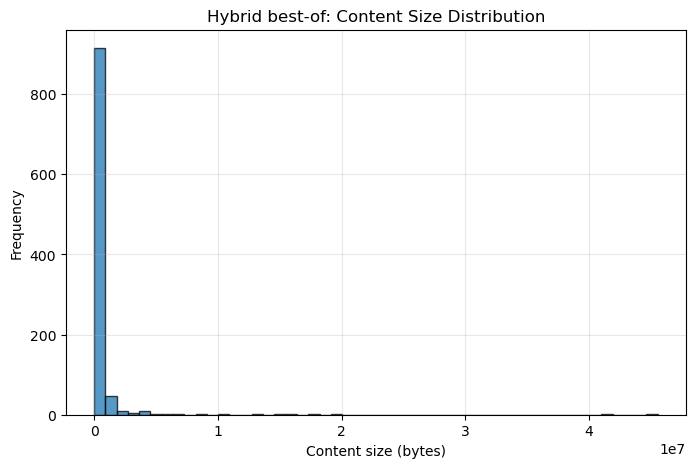

In [16]:
def hist_bytes(df, title):
    if df.empty:
        print(f"No data for {title}")
        return

    plt.figure(figsize=(8,5))
    df["bytes_len"].plot(kind="hist", bins=50, alpha=0.75, edgecolor="black")
    plt.xlabel("Content size (bytes)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

hist_bytes(http_only,   "HTTP-only: Content Size Distribution")
hist_bytes(browser_only,"Browser-only: Content Size Distribution")
hist_bytes(hybrid,      "Hybrid best-of: Content Size Distribution")

## 10. Saving artifacts for offline analysis

All detailed results and aggregates are saved as Parquet files under `artifacts/`, so they can be reused in the one-pager PDF or explored later without re-running the whole scrape.

In [17]:
from src.storage import save_df

print("Saving detailed results...")

save_df(df_http,    "http_results")
save_df(df_browser, "browser_results")
save_df(hybrid,     "hybrid_best_of")
save_df(summary_cost, "policy_summary_with_cost")

print("Saved all artifacts to artifacts/output/*.parquet")

Saving detailed results...
Saved /Users/gabrielzackon/tavily-scraper/results/http_results.csv
Saved /Users/gabrielzackon/tavily-scraper/results/browser_results.csv
Saved /Users/gabrielzackon/tavily-scraper/results/hybrid_best_of.csv
Saved /Users/gabrielzackon/tavily-scraper/results/policy_summary_with_cost.csv
Saved all artifacts to artifacts/output/*.parquet
